In [1]:
import numpy as np
import math, random

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from geometry.model import Model, combine_observations, get_mesh
from geometry.utils.visualisation import illustrate_points, illustrate_mesh, illustrate_voxels
from geometry.voxel_grid import VoxelGrid

from rl.environment import Environment, CombiningObservationsWrapper
from rl.environment import StepPenaltyRewardWrapper, DepthMapWrapper
from rl.environment import VoxelGridWrapper, VoxelWrapper
from rl.environment import FrameStackWrapper, ActionMaskWrapper


from rl.dqn import CnnDQN, CnnDQNA, VoxelDQN
from rl.utils import DiskReplayBuffer, ReplayBuffer


# !conda install -c conda-forge pyembree
# !conda install -c conda-forge igl
# !pip install Cython
# !pip install gym

In [2]:
def plot(frame_idx, rewards, novps, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('number of vp: %s' % np.mean(novps[-10:]))
    plt.plot(novps)
    plt.subplot(133)
    plt.title('loss')
    if len(losses) > 20:
        plt.plot(losses[20:])
    else:
        plt.plot(losses)
    plt.show()

## DQN

In [3]:
USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    torch.cuda.set_device(0)
    print(torch.cuda.current_device())

0


In [11]:
env = Environment(illustrate=False, models_path="./data/1kabc/simple/train/", number_of_view_points=100)
# env = CombiningObservationsWrapper(env)
# env = StepPenaltyRewardWrapper(env, weight=1.0)
# env = DepthMapWrapper(env)

env = VoxelGridWrapper(env)
env = CombiningObservationsWrapper(env)
env = VoxelWrapper(env)
env = StepPenaltyRewardWrapper(env)
env = FrameStackWrapper(env, num_stack=4, lz4_compress=False)
env = ActionMaskWrapper(env)

In [12]:
from rl.dqn import CnnDQN, CnnDQNA

model = VoxelDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    model = model.cuda()

replay_initial = 1000
replay_buffer = DiskReplayBuffer(capacity=100000,
                                 overwrite=True,
                                 location="buffer_voxels/",
                                 num_actions=env.action_space.n,
                                 observation_dtype=env.observation_space.dtype,
                                 observation_shape=env.observation_space.shape)

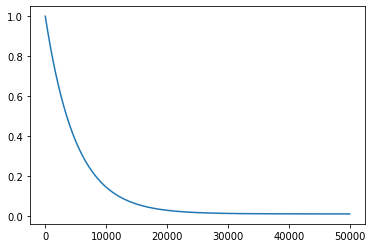

In [13]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 5000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * \
        math.exp(-1. * frame_idx / epsilon_decay)

plt.plot([epsilon_by_frame(i) for i in range(50000)])

### Training

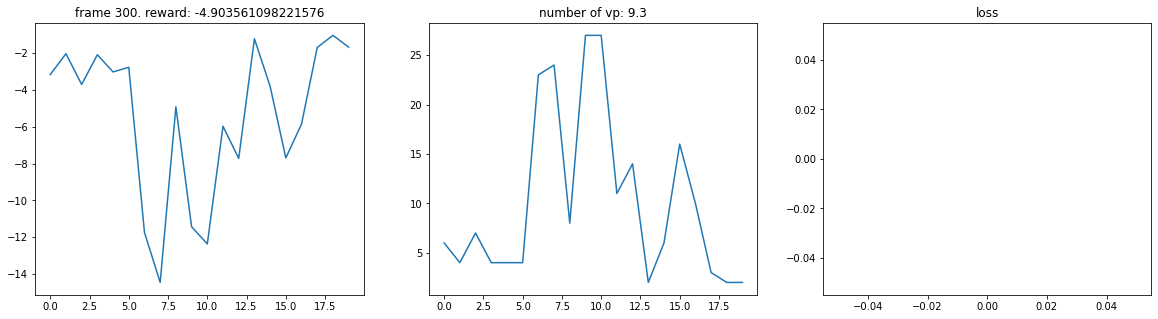

Action:  6 (random)
0.253144485056977 0.6394230372270522 0.8925675222840292
Action:  65 (random)
0.2697000645022576 0.6228674577817717 0.8925675222840292
Action:  63 (random)
0.3310847129649538 0.6116805172474985 0.9427652302124523
Action:  98
0.2856912491937218 0.6570739810187305 0.9427652302124523
Action:  48 (random)


In [ ]:
num_frames = 100000
batch_size = 256
save_model_path = "./models/abc-vdqn-{}.pt"


losses = []
all_rewards = []
all_nofs = []
episode_reward = 0

state, _, mask = env.reset()
nof_vp = 0
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, mask, epsilon)

    next_state, reward, done, _, mask = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done, mask)

    state = next_state
    episode_reward += reward
    nof_vp += 1

    # env.render(action, state)

    if done:
        # final_reward = env.final_reward()
        # print("Number of View Points: ", nof_vp, " Hausdorff reward: ", final_reward)
        print("Frame: ", frame_idx, "Number of View Points: ", nof_vp)
        print()

        state, _, mask = env.reset()
        all_rewards.append(episode_reward)
        all_nofs.append(nof_vp)
        episode_reward = 0
        nof_vp = 0

    elif nof_vp > 50:
        state, _, mask = env.reset()
        episode_reward = 0
        nof_vp = 0
        
    if len(replay_buffer) > replay_initial:
        batch = replay_buffer.sample(batch_size)
        loss = model.compute_td_loss(*batch)
        losses.append(loss.item())
        
    if frame_idx % 100 == 0:
        plot(frame_idx, all_rewards, all_nofs, losses)
        
    if frame_idx % 500 ==  0:
        torch.save(model, save_model_path.format(frame_idx))

In [24]:
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda()

In [25]:
%%time
state      = Variable(torch.FloatTensor(state))
next_state = Variable(torch.FloatTensor(next_state), volatile=True)
action     = Variable(torch.LongTensor(np.concatenate(action)))
reward     = Variable(torch.FloatTensor(np.concatenate(reward)))
done       = Variable(torch.FloatTensor(np.concatenate(done)))
mask       = Variable(torch.FloatTensor(mask))

CPU times: user 308 ms, sys: 108 ms, total: 416 ms
Wall time: 46.9 ms


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.


In [170]:
for i, r in enumerate(replay_buffer._rewards):
    if r == 0:
        break

In [171]:
i

1206

In [174]:
replay_buffer = DiskReplayBuffer(capacity=100000,
                                 overwrite=False,
                                 location="buffer_voxels/",
                                 num_actions=env.action_space.n,
                                 observation_dtype=env.observation_space.dtype,
                                 observation_shape=env.observation_space.shape)

In [162]:
import os

class DiskReplayBuffer:
    def __init__(
            self,
            capacity,
            observation_shape,
            observation_dtype,
            num_actions,
            overwrite=False,
            location='.',
            name='replay_buffer'):
        self._observation_shape = observation_shape
        self._observation_dtype = observation_dtype
        self._num_actions = num_actions
        self.capacity = capacity

        file_path = os.path.join(location, name)
        
        mode= 'w+'
        if os.path.exists(f'{file_path}.obs') and not overwrite:
            mode = 'r+'

        self._states = np.memmap(f'{file_path}.obs', dtype=observation_dtype, mode=mode,
                                       shape=(capacity,) + observation_shape)
        # TODO optimize
        self._next_states = np.memmap(f'{file_path}.nextobs', dtype=observation_dtype, mode=mode,
                                      shape=(capacity,) + observation_shape)
        self._actions = np.memmap(f'{file_path}.actions', dtype=np.int32, mode=mode,
                                  shape=(capacity, 1))
        self._rewards = np.memmap(f'{file_path}.rewards', dtype=np.float32, mode=mode,
                                  shape=(capacity, 1))
        self._done = np.memmap(f'{file_path}.done', dtype=np.uint8, mode=mode,
                               shape=(capacity, 1))
        self._mask = np.memmap(f'{file_path}.mask', dtype=bool, mode=mode,
                               shape=(capacity, self._num_actions))

        self._top = 0
        self._size = 0
        
        if mode 
        for i, r in enumerate(replay_buffer._rewards):
        if r == 0:
            break

    def __len__(self):
        return self._size

    def push(self, state, action, reward, next_state, done, mask):
        self._states[self._top] = state
        self._actions[self._top] = action
        self._rewards[self._top] = reward
        self._next_states[self._top] = next_state
        self._done[self._top] = done
        self._mask[self._top] = mask

        self._top = (self._top + 1) % self.capacity
        if self._size < self.capacity:
            self._size += 1

    def sample(self, batch_size=1):
        indices = np.random.choice(self._size, batch_size)
        
        state, action, reward, next_state, done, mask = [], [], [], [], [], []
        for index in indices:
            state.append(self._states[index])
            action.append(self._actions[index])
            reward.append(self._rewards[index])
            next_state.append(self._next_states[index])
            done.append(self._done[index])
            mask.append(self._mask[index])
            
        state      = Variable(torch.FloatTensor(state))
        next_state = Variable(torch.FloatTensor(next_state), volatile=True)
        action     = Variable(torch.LongTensor(np.concatenate(action)))
        reward     = Variable(torch.FloatTensor(np.concatenate(reward)))
        done       = Variable(torch.FloatTensor(np.concatenate(done)))
        mask       = Variable(torch.FloatTensor(mask))
            
        return state, action, reward, next_state, done, mask    

In [84]:
mesh = env.env.env.env.env.model.mesh
illustrate_mesh(mesh.vertices, mesh.faces)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[2, -3, 0.2, 0.0, 0…

In [136]:
state, action, mask = env.reset()
for t in range(5):
    action = model.act(state, mask, epsilon=0.0)

    state, reward, done, info, mask = env.step(action)

/tf/NextBestViewRL/rl/utils.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if USE_CUDA else autograd.Variable(*args, **kwargs)


Action:  21
0.4401918758930394 -0.07150870612593818 0.3686831697671012
Action:  21
0.4401918758930394 -0.07150870612593818 0.3686831697671012
Action:  21
0.4401918758930394 -0.07150870612593818 0.3686831697671012
Action:  21
0.4401918758930394 -0.07150870612593818 0.3686831697671012
Action:  21
0.4401918758930394 -0.07150870612593818 0.3686831697671012


In [149]:
def compute_metrics(env, iter_cnt=10, max_iter=30):
    rewards, final_rewards, novp = [], [], []
    for _ in range(iter_cnt):
        state, action, mask = env.reset()
        episode_reward = 0.0
        for t in range(max_iter):
#             action = model.act(state, mask, epsilon=0.0)
            

            s   = autograd.Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True).cuda()
            m = autograd.Variable(torch.FloatTensor(np.float32(mask)), volatile=True).cuda()
            q_value = model.forward(s)
            a = torch.nn.functional.softmax(q_value)
            a *= m
            action = a.argmax().item()
            print(action)

            state, reward, done, info, mask = env.step(action)
            # print("REWARD: ", reward)
#             env.render(action, state)
            episode_reward += reward

            if done:
                break

        final_reward = 0
        # final_reward = env.final_reward()
        # episode_reward += 1.0 / final_reward
        rewards.append(episode_reward)
        final_rewards.append(final_reward)
        novp.append(t + 1)
    return np.mean(rewards), np.mean(final_rewards), np.mean(novp)

In [150]:
agent_func = lambda s : model.act(s, epsilon=0.0)
result = compute_metrics(env)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


43
0.2957859890847276 0.09135631811404055 0.38714230719876813
27
0.4030598550594972 0.026171506418752488 0.4292313614782497
44
0.16762100742596403 0.34347869743737486 0.5110997048633389
89
0.4266350541290149 0.5234483540578194 0.9500834081868343
43
0.4240290226205719 0.058087586884572606 0.4821166095051445
44
0.34699103713188223 0.1953901485614054 0.5423811856932876
99
0.36043533930857874 0.2961055720094027 0.6565409113179814
47
0.3565941101152369 0.3406131412321418 0.6972072513473787
46
0.176056338028169 0.5270303841668335 0.7030867221950025
48
0.3958600085360649 0.32241534668196553 0.7182753552180304
94
0.38369611609048226 0.42473112545777836 0.8084272415482606
10
0.3546734955185659 0.46453277591700487 0.8192062714355708
53
0.40887750746905677 0.43286673554907157 0.8417442430181283
25
0.35488689714041827 0.4951865962451771 0.8500734933855953
54
0.3480580452411438 0.5088748308000125 0.8569328760411563
81
0.3787878787878788 0.48255460038899534 0.8613424791768741
27
0.45027742210840804 

In [152]:
result

(-4.834530918079388, 0.0, 8.9)

In [151]:
print((6 * 256 * 256 * 8) / 1e9 * 3000, 'G')
print((10 * 512 * 512 * 8) / 1e9 * 5000, 'G')
print(1e6 * 10 * 512 * 512 * 4 / 2 ** 40, 'T')
print(1e5 * 64 * 64 * 64 * 4 * 4 / 2 ** 40, 'T')

9.437184 G
104.8576 G
9.5367431640625 T
0.3814697265625 T


In [ ]:
TODO Today:
    1. + check DQN with A, S as input -> send Sergey
    2. + Smaller depth_maps (6 * 256 * 256)
    3. + Illustrate reward as area + novp
    4. + Distributed Buffer
    5. + Buffer on hard disk (memmap)
    6. Floats to int
    7. GPU raycasting
    8. * Greedy algo
    9. * Voxels
    10. CNN different shapes input
    11. Preprocessed depth_maps
    
    10. Overfit experiments 
    11. ABC experiment
    
    12. Experiment radius = 1.0
    13. Experiments with smaller reward fine
    14. Experiment with different DQN-s
    15. ABC - write random model reading
    

Ideas:
    1. Add fine for same view_point
    
Big Experiments:
    1. Voxels
    2. PointNet
    3. Context (N first view_points)
    4. Meta-learning, подавать от простой к сложной детальке

In [15]:
difficult = [
    "00020107_b27a1602d1d44a3d89140ce4_007.obj",
    "00010095_5ae1ee45b583467fa009adc4_006.obj",
    "00010163_ccef4063b69f428e91b498c9_008.obj",
    "00010145_77759770d8cd48af80775d86_002.obj",
    "00010153_556de37e0a7447fcbfbdfd22_000.obj",
    "00010162_ccef4063b69f428e91b498c9_007.obj",
    "00020074_37170a1ba80747f1a1478985_000.obj",
    "00020077_bf146f0c5dee4199be920a21_000.obj",
    "00020080_7a689565e1e0481ca3ad4a6f_000.obj",
    "00010164_ccef4063b69f428e91b498c9_009.obj",
    "00010179_f91d806ac1e34ea1b14e23be_000.obj",
    "00020095_842a932142a9431784488344_000.obj",
    "00020097_e24ecc9c647f4bd1832bfb1d_000.obj",
    "00020106_b27a1602d1d44a3d89140ce4_006.obj",
    "00020141_b27a1602d1d44a3d89140ce4_041.obj",
    "00020155_b27a1602d1d44a3d89140ce4_055.obj",
    "00020186_b27a1602d1d44a3d89140ce4_086.obj",
    "00020202_b27a1602d1d44a3d89140ce4_102.obj",
    "00020203_b27a1602d1d44a3d89140ce4_103.obj",
    "00020213_1f65839d7f6c42bf8c2b3391_000.obj"]